<a href="https://colab.research.google.com/github/1900690/yolov8-android/blob/main/yolov8-train-convert-tflite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# カスタムデータセットでYOLOv8の物体検出androidアプリを作成する方法

---
YOLOv8のnモデルを学習させ、tensorflow lite 型モデルに変換することで、android studio上で、androidスマートフォンとスマートグラスにインストール可能な` .apk` ファイルを作成できます。


[参考動画](hサイトs://youtu.be/dl7rCmvIyiI)


[参考webサイト](https://github.com/AarohiSingla/Object-Detection-Android-App?tab=readme-ov-file)



## 始める前に


####fastlabelで印付き画像をエクスポートする

<p align="center">
  <img src="https://fastlabel.notion.site/image/https%3A%2F%2Ffiles.readme.io%2F0d7e2c2-_2022-06-24_16.14.37.png?table=block&id=70683ebb-9d66-43fc-a849-9dca81ca7a65&spaceId=b09acb41-4740-4d1c-87a6-4fb648f2ad1c&width=2000&userId=&cache=v2" width=80%>
 <br>
  fastlabelのエクスポートタブで'出力形式'を'YOLO'、'画像出力'を'オリジナル'を選択してエクスポートする
</p>

####GPUを使用して計算時間の短縮を行う

Google Colabでこのノートブックを実行している場合、`ランタイム` -> `ランタイムのタイプを変更` -> `ハードウェアアクセラレータ` に移動し、`GPU`を選択し、`保存`をクリックします。これでノートブックがGPUを使用するようになり、モデルのトレーニング時間が大幅に短縮されます。


In [ ]:
#@markdown グーグルドライブへのアクセスを行い、学習した重みの保存場所を確保する。
#ドライブマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@markdown 学習用のYOLOv8パッケージをインストールする。
!git clone https://github.com/ultralytics/ultralytics
!pip install -qe ultralytics

Cloning into 'ultralytics'...
remote: Enumerating objects: 28969, done.
remote: Counting objects: 100% (335/335), done.
remote: Compressing objects: 100% (177/177), done.
remote: Total 28969 (delta 211), reused 255 (delta 158), pack-reused 28634
Receiving objects: 100% (28969/28969), 14.66 MiB | 22.54 MiB/s, done.
Resolving deltas: 100% (20788/20788), done.
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 63.6 MB/s eta 0:00:00
  Building editable for ultralytics (pyproject.toml) ... done


In [ ]:
#@markdown エクスポートしたzipファイルをアップロード

#ライブラリをインポート(機能を使えるようにする)
import shutil
import os
from google.colab import files
import math


#すでにフォルダがある場合は消す
if os.path.exists("/content/datasets"):
  shutil.rmtree("/content/datasets")

#データをアップロード
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
#データを解凍
shutil.unpack_archive('/content/'+file_name, '/content/')
#zipを消す
os.remove('/content/'+file_name)

Saving syakuyaku500_20240626214945.zip to syakuyaku500_20240626214945.zip


In [ ]:
#@markdown 画像を学習用と検証用とテスト用に分割

#@markdown ※初めに全体をtrainとvalidに分割、分割したtrainからさらにtestを分割する
#ライブラリをインポート
import shutil
import os
from sklearn.model_selection import train_test_split
import math

#分割元のパスを作成
originals='/content/original'
annotations='/content/yolo/annotations'

#分割先のパスを作成
train_images = '/content/datasets/train/images'
train_labels = '/content/datasets/train/labels'
valid_images = '/content/datasets/valid/images'
valid_labels = '/content/datasets/valid/labels'
test_images = '/content/datasets/test/images'
test_labels = '/content/datasets/test/labels'

#分割先のファイルを作成
if os.path.exists('/content/datasets/'):
  shutil.rmtree('/content/datasets/')
if not os.path.exists('/content/datasets/'):
  os.makedirs(train_images)
  os.makedirs(train_labels)
  os.makedirs(valid_images)
  os.makedirs(valid_labels)
  os.makedirs(test_images)
  os.makedirs(test_labels)


#フォルダの中のファイルのリストを作成
read_files_annotations = os.listdir(annotations)
read_files_annotations.sort()
read_files_originals= os.listdir(originals)
read_files_originals.sort()


valid分割割合=0.2#@param {type:"slider", min:0, max:1, step:0.1}
test分割割合=0.1#@param {type:"slider", min:0, max:1, step:0.1}

#分割割合に合わせてファイルのリストを分割
annotations_train_test, annotations_valid, originals_train_test, originals_valid = train_test_split(read_files_annotations,read_files_originals,test_size=valid分割割合)
annotations_train, annotations_test, originals_train, originals_test = train_test_split(annotations_train_test,originals_train_test,test_size=test分割割合)


#画像とアノテーションを分ける
for filename in annotations_train:
  shutil.copy( annotations+"/"+filename,train_labels)
for filename in annotations_valid:
  shutil.copy( annotations+"/"+filename,valid_labels)
for filename in annotations_test:
  shutil.copy( annotations+"/"+filename,test_labels)

for filename in originals_train:
  shutil.copy( originals+"/"+filename,train_images)
for filename in originals_valid:
  shutil.copy( originals+"/"+filename,valid_images)
for filename in originals_test:
  shutil.copy( originals+"/"+filename,test_images)

#最大公約数を計算
greatest_common_divisor=math.gcd(sum(os.path.isfile(os.path.join(train_images, name)) for name in os.listdir(train_images)),sum(os.path.isfile(os.path.join(valid_images, name)) for name in os.listdir(valid_images)))

#分割されたファイル数を表示
print("train/imagesは",sum(os.path.isfile(os.path.join(train_images, name)) for name in os.listdir(train_images)),"枚")
print("train/labelsは",sum(os.path.isfile(os.path.join(train_labels, name)) for name in os.listdir(train_labels)),"枚")
print("valid/imagesは",sum(os.path.isfile(os.path.join(valid_images, name)) for name in os.listdir(valid_images)),"枚")
print("valid/labelsは",sum(os.path.isfile(os.path.join(valid_labels, name)) for name in os.listdir(valid_labels)),"枚")
print("test/imagesは",sum(os.path.isfile(os.path.join(test_images, name)) for name in os.listdir(test_images)),"枚")
print("test/labelsは",sum(os.path.isfile(os.path.join(test_labels, name)) for name in os.listdir(test_labels)),"枚")
print("最大公約数は",greatest_common_divisor,"<-この数はbatchを決める際に必要")

train/imagesは 72 枚
train/labelsは 72 枚
valid/imagesは 20 枚
valid/labelsは 20 枚
test/imagesは 8 枚
test/labelsは 8 枚
最大公約数は 4 <-この数はbatchを決める際に必要


####学習データに関する詳細ファイルを作成

In [ ]:
#以下の★の部分を学習目的に応じて書き換える
%%writefile /content/datasets/data.yaml

#ここは触らない
train: ../train/images
val: ../valid/images

#★検出する項目の数を記載
nc: 2

#★検出する項目の数だけ項目名を記載する
names: ['OK','NG']

Writing /content/datasets/data.yaml


## 学習開始
下に書いてある項目を設定し、学習をスタートさせる


*   epochは学習回数
*   [batch](https://qiita.com/kenta1984/items/bad75a37d552510e4682#:~:text=%E3%83%87%E3%82%A3%E3%83%BC%E3%83%97%E3%83%A9%E3%83%BC%E3%83%8B%E3%83%B3%E3%82%B0%E3%81%A7%E3%81%AF,%E3%83%87%E3%83%BC%E3%82%BF%E3%81%AE%E6%95%B0%E3%82%92%E3%83%90%E3%83%83%E3%83%81%E3%82%B5%E3%82%A4%E3%82%BA%E3%81%A8%E5%91%BC%E3%81%B3%E3%81%BE%E3%81%99%E3%80%82)はバッチサイズ（最大公約数に合わせることが多い）
*   plotsは学習結果を保存するかどうか（True or False）
*   imgszは学習に使う画像のサイズ
*   modelは学習に使用するモデル
*   dataはそのままで



In [ ]:
%cd /content/

!yolo task=detect mode=train \
epochs=10 \
batch=4 \
plots=True \
imgsz=640\
model=/content/weights/yolov8n.pt \
data=/content/datasets/data.yaml

/content
100% 6.25M/6.25M [00:00<00:00, 135MB/s]
Ultralytics YOLOv8.2.48 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/content/weights/yolov8n.pt, data=/content/datasets/data.yaml, epochs=10, time=None, patience=100, batch=4, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_c

##性能確認

###confusionマトリックス
<p align="center">
  <img src="https://image.itmedia.co.jp/ait/articles/2208/08/l_di-01.gif" width=50%>
 <br>
  TPとTNの数が大きいほど性能が良い
</p>

[Errno 2] No such file or directory: '{HOME}'
/content


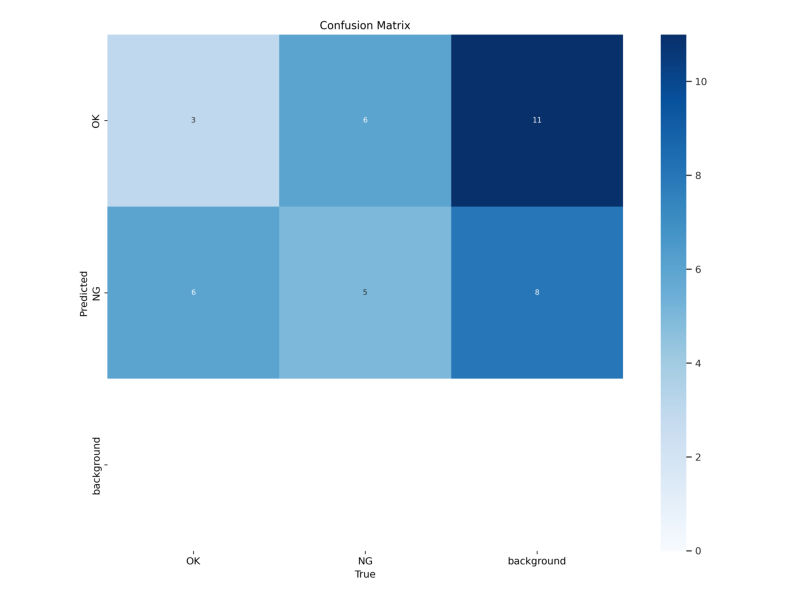

In [ ]:
#@title confusionマトリックスを表示
#@markdown 学習終了時に表示されるruns/detect/trainの後につく数を設定する。
#@markdown ※数字がない場合は１を記入してください
trainの後につく数字 = 2 # @param {type:"number"}
%cd {HOME}
from matplotlib import pyplot as plt
import cv2

if trainの後につく数字==1:
    im = cv2.imread('/content/ultralytics/runs/detect/train/confusion_matrix.png')
    plt.figure(figsize=(10,10))
    plt.axis('off')
    im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.imshow(im_rgb)
else:
    im = cv2.imread('/content/ultralytics/runs/detect/train'+str(trainの後につく数字)+'/confusion_matrix.png')
    plt.figure(figsize=(10,10))
    plt.axis('off')
    im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.imshow(im_rgb)

##学習の推移
重要な値は[metrics/mAP50](https://medium.com/axinc/map-%E7%89%A9%E4%BD%93%E6%A4%9C%E5%87%BA%E3%83%A2%E3%83%87%E3%83%AB%E3%81%AE%E8%A9%95%E4%BE%A1%E6%8C%87%E6%A8%99-956a786e8c3d#:~:text=AP%E3%81%AB%E3%81%A4%E3%81%84%E3%81%A6,%E3%81%AB%E3%81%AA%E3%82%8A%E3%81%BE%E3%81%99%E3%80%82)と[metrics/mAP50-90](https://docs.ultralytics.com/ja/guides/yolo-performance-metrics/#:~:text=mAP50%2D95%3A%200.50%E3%81%8B%E3%82%890.95%E3%81%BE%E3%81%A7%E3%81%AE%E6%A7%98%E3%80%85%E3%81%AAIoU%E9%96%BE%E5%80%A4%E3%81%A7%E8%A8%88%E7%AE%97%E3%81%95%E3%82%8C%E3%81%9F%E5%B9%B3%E5%9D%87%E5%B9%B3%E5%9D%87%E7%B2%BE%E5%BA%A6%E3%80%82%E7%95%B0%E3%81%AA%E3%82%8B%E6%A4%9C%E5%87%BA%E9%9B%A3%E6%98%93%E5%BA%A6%E3%81%AB%E3%81%8A%E3%81%91%E3%82%8B%E3%83%A2%E3%83%87%E3%83%AB%E3%81%AE%E3%83%91%E3%83%95%E3%82%A9%E3%83%BC%E3%83%9E%E3%83%B3%E3%82%B9%E3%82%92%E5%8C%85%E6%8B%AC%E7%9A%84%E3%81%AB%E8%A6%8B%E3%82%8B%E3%81%93%E3%81%A8%E3%81%8C%E3%81%A7%E3%81%8D%E3%82%8B%E3%80%82)この二つが１に近いほど性能が良い

*   [metorics/recall(B)](https://medium.com/axinc/map-%E7%89%A9%E4%BD%93%E6%A4%9C%E5%87%BA%E3%83%A2%E3%83%87%E3%83%AB%E3%81%AE%E8%A9%95%E4%BE%A1%E6%8C%87%E6%A8%99-956a786e8c3d#:~:text=Precision%E3%81%AF%E6%A4%9C%E5%87%BA%E3%81%97%E3%81%9F%E3%83%90%E3%82%A6%E3%83%B3%E3%83%87%E3%82%A3%E3%83%B3%E3%82%B0%E3%83%9C%E3%83%83%E3%82%AF%E3%82%B9%E3%81%8C%E6%AD%A3%E3%81%97%E3%81%84%E6%AF%94%E7%8E%87%E3%82%92%E7%A4%BA%E3%81%97%E3%81%BE%E3%81%99%E3%80%82%E9%96%93%E9%81%95%E3%81%A3%E3%81%9F%E3%83%90%E3%82%A6%E3%83%B3%E3%83%87%E3%82%A3%E3%83%B3%E3%82%B0%E3%83%9C%E3%83%83%E3%82%AF%E3%82%B9%E3%82%92%E9%81%8E%E5%89%B0%E3%81%AB%E6%A4%9C%E5%87%BA%E3%81%97%E3%81%A6%E3%81%97%E3%81%BE%E3%81%86%E9%81%8E%E6%A4%9C%E5%87%BA%E3%81%8C%E3%81%AA%E3%81%91%E3%82%8C%E3%81%B01.0%E3%81%AB%E3%81%AA%E3%82%8A%E3%81%BE%E3%81%99%E3%80%82%E3%81%9F%E3%81%A0%E3%81%97%E3%80%81%E6%A4%9C%E5%87%BA%E3%81%99%E3%81%B9%E3%81%8D%E3%83%90%E3%82%A6%E3%83%B3%E3%83%87%E3%82%A3%E3%83%B3%E3%82%B0%E3%83%9C%E3%83%83%E3%82%AF%E3%82%B9%E3%82%92%E6%A4%9C%E5%87%BA%E3%81%A7%E3%81%8D%E3%81%A6%E3%81%84%E3%81%AA%E3%81%84%E3%80%81%E6%9C%AA%E6%A4%9C%E5%87%BA%E3%81%8C%E3%81%82%E3%81%A3%E3%81%A6%E3%82%821.0%E3%81%AB%E3%81%AA%E3%82%8A%E3%81%BE%E3%81%99%E3%80%82):検出したバウンディングボックスが正しい比率
*   [metorics/presicion(B)](https://medium.com/axinc/map-%E7%89%A9%E4%BD%93%E6%A4%9C%E5%87%BA%E3%83%A2%E3%83%87%E3%83%AB%E3%81%AE%E8%A9%95%E4%BE%A1%E6%8C%87%E6%A8%99-956a786e8c3d#:~:text=Recall%E3%81%AF%E6%A4%9C%E5%87%BA%E3%81%99%E3%81%B9%E3%81%8D%E3%83%90%E3%82%A6%E3%83%B3%E3%83%87%E3%82%A3%E3%83%B3%E3%82%B0%E3%83%9C%E3%83%83%E3%82%AF%E3%82%B9%E3%82%92%E6%A4%9C%E5%87%BA%E3%81%A7%E3%81%8D%E3%81%A6%E3%81%84%E3%82%8B%E6%AF%94%E7%8E%87%E3%82%92%E7%A4%BA%E3%81%97%E3%81%BE%E3%81%99%E3%80%82%E6%A4%9C%E5%87%BA%E3%81%99%E3%81%B9%E3%81%8D%E3%83%90%E3%82%A6%E3%83%B3%E3%83%87%E3%82%A3%E3%83%B3%E3%82%B0%E3%83%9C%E3%83%83%E3%82%AF%E3%82%B9%E3%82%92%E6%A4%9C%E5%87%BA%E3%81%A7%E3%81%8D%E3%81%A6%E3%81%84%E3%81%AA%E3%81%84%E6%9C%AA%E6%A4%9C%E5%87%BA%E3%81%8C%E3%81%AA%E3%81%91%E3%82%8C%E3%81%B01.0%E3%81%AB%E3%81%AA%E3%82%8A%E3%81%BE%E3%81%99%E3%80%82%E3%81%9F%E3%81%A0%E3%81%97%E3%80%81%E9%96%93%E9%81%95%E3%81%A3%E3%81%9F%E3%83%90%E3%82%A6%E3%83%B3%E3%83%87%E3%82%A3%E3%83%B3%E3%82%B0%E3%83%9C%E3%83%83%E3%82%AF%E3%82%B9%E3%82%92%E9%81%8E%E5%89%B0%E3%81%AB%E6%A4%9C%E5%87%BA%E3%81%97%E3%81%A6%E3%81%97%E3%81%BE%E3%81%86%E9%81%8E%E6%A4%9C%E5%87%BA%E3%81%8C%E3%81%82%E3%81%A3%E3%81%A6%E3%82%821.0%E3%81%AB%E3%81%AA%E3%82%8A%E3%81%BE%E3%81%99%E3%80%82):検出すべきバウンディングボックスを検出できている比率



[Errno 2] No such file or directory: '{HOME}'
/content


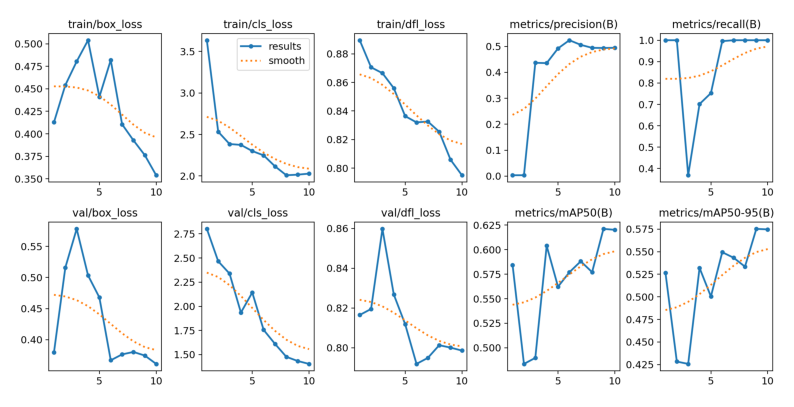

In [ ]:
#@title 学習の推移を表示

#@markdown 学習終了時に表示されるruns/detect/trainの後につく数を設定する。
#@markdown ※数字がない場合は１を記入してください

trainの後につく数字 = 2 # @param {type:"number"}
%cd {HOME}
from matplotlib import pyplot as plt
import cv2

if trainの後につく数字==1:
    im = cv2.imread('/content/ultralytics/runs/detect/train/results.png')
    plt.figure(figsize=(10,10))
    plt.axis('off')
    im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.imshow(im_rgb)
else:
    im = cv2.imread('/content/ultralytics/runs/detect/train'+str(trainの後につく数字)+'/results.png')
    plt.figure(figsize=(10,10))
    plt.axis('off')
    im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.imshow(im_rgb)

In [ ]:
##@title **注意**：学習が終了したら、重みをdriveのフォルダに移しておくこと、タブを消去すると計算結果がすべて消える

#@markdown 学習終了時に表示されるruns/detect/trainの後につく数を設定してdriveへ重みを移動
trainの後につく数字 = 2 # @param {type:"number"}

#グーグルドライブにコピー
%cd {HOME}
from IPython.display import Image
if trainの後につく数字==1:
  shutil.copyfile("/content/ultralytics/runs/detect/train/weights/best.pt","/content/drive/MyDrive/best.pt")
else:
  shutil.copyfile("/content/ultralytics/runs/detect/train"+str(trainの後につく数字)+"/weights/best.pt","/content/drive/MyDrive/best"+str(trainの後につく数字)+".pt")

/content


##学習したAIによる推論

下に書いてある項目を設定し、推論をスタートさせる


*   modelには学習した重みまでのパスを設定する
*   confは確度が何％になったら枠を表示するのか
*   imgszは推論に使う画像のサイズ
*   show_confは確度を表示するかどうか
*   save_txtは枠の座標を記録するかどうか（必ずTrueにすること）
*   deviceはGPUを使うかどうか（そのままで）
*   sourceは推論する画像のフォルダまでのパス（そのままで）

In [ ]:
%cd /content/

!yolo task=detect \
      mode=predict \
      model= /content/ultralytics/runs/detect/train2/weights/best.pt\
      conf=0.4 \
      imgsz=640\
      show_conf=False \
      save_txt=True \
      device=0\
      source="/content/datasets/test/images"

/content
Ultralytics YOLOv8.2.48 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3006038 parameters, 0 gradients, 8.1 GFLOPs

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
image 1/8 /content/datasets/test/images/001 (3).jpg: 640x480 1 OK, 1 NG, 96.4ms
image 2/8 /content/datasets/test/images/004 (4).jpg: 640x480 1 OK, 6.4ms
image 3/8 /content/datasets/test/images/007 (7).jpg: 640x480 1 OK, 6.0ms
image 4/8 /content/datasets/test/images/010 (3).jpg: 640x480 1 OK, 6.0ms
image 5/8 /content/datasets/test/images/010 (4).jpg: 640x480 1 OK, 1 NG, 6.0ms
image 6/8 /content/datasets/test/images/015 (3).jpg: 640x480 1 OK, 5.9ms
image 7/8 /conte

##学習済みモデルをTensorFlow Liteモデルに変換

In [ ]:
!yolo export model=/content/ultralytics/runs/detect/train2/weights/best.pt format=tflite

Ultralytics YOLOv8.2.48 🚀 Python-3.10.12 torch-2.3.0+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 3006038 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from '/content/ultralytics/runs/detect/train2/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 6, 8400) (5.9 MB)
requirements: Ultralytics requirements ['sng4onnx>=1.0.1', 'onnx_graphsurgeon>=0.3.26', 'onnx>=1.12.0', 'onnx2tf>1.17.5,<=1.22.3', 'onnxslim>=0.1.31', 'tflite_support', 'onnxruntime'] not found, attempting AutoUpdate...
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.4/56.4 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 78.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 435.0/435.0 kB 286.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.4/128.4 kB 317.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/6

In [ ]:
#@title モデルをダウンロード

#@markdown 学習終了時に表示される/content/ultralytics/runs/detect/trainの後につく数を設定する。
#@markdown ※数字がない場合は１を記入してください

trainの後につく数字 = 2 # @param {type:"number"}
import shutil
import os
from google.colab import files

if trainの後につく数字==1:
    files.download('/content/ultralytics/runs/detect/train/weights/best_saved_model/best_float32.tflite')
else:
    files.download('/content/ultralytics/runs/detect/train'+str(trainの後につく数字)+'/weights/best_saved_model/best_float32.tflite')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#アプリを作成

##android studioをインストール

Androidアプリを開発するための公式の開発ツール。[インストールチュートリアル](https://developer.android.com/codelabs/basic-android-kotlin-compose-install-android-studio?hl=ja#0)に従ってインストールする

##画像解析アプリ作成用パッケージをダウンロード
[ここ](https://github.com/1900690/yolov8-android/releases/download/android_app/android_app.zip)をクリックして必要なパッケージをダウンロードする。ダウンロードしたら解凍すること。


##パッケージを開く
<p align="center">
  <img src="https://github.com/1900690/yolov8-android/blob/main/images/%E8%A7%A3%E8%AA%AC%EF%BC%92.png?raw=1" width=80%>
 <br>
  android studioを開いたら、右上の[open]をクリックして、先ほどダウンロードしたパッケージの[android_app]を選択して[OK]を押す
</p>

##学習したAIに置き換える
1.   \android_app\app\src\main\assetsの中の`labels.txt`を開き検出したいclassの名前に書き換える
2.   ダウンロードしておいた学習済みモデルの名前を`model.tflite`と書き換え\android_app\app\src\main\assetsの中に入れる



##`.apk`ファイルを作成
<p align="center">
  <img src="https://github.com/1900690/yolov8-android/blob/main/images/%E8%A7%A3%E8%AA%AC%EF%BC%93.png?raw=1" width=80%>
 <br>
  右上の象のマークをクリックして同期する
</p>
<p align="center">
  <img src="https://github.com/1900690/yolov8-android/blob/main/images/%E8%A7%A3%E8%AA%AC%EF%BC%94.png?raw=1" width=80%>
 <br>
  左上のメニューバーから`Build`→`Build App Bundle(s)/APK(s)`→`Build APK(s)`をクリックしてAPKファイルを作成
</p>



##アプリインストール

1.   作成した[APKファイル](https://gimo.jp/glossary/details/apk_file.html#:~:text=APK%E3%83%95%E3%82%A1%E3%82%A4%E3%83%AB-,APK%E3%83%95%E3%82%A1%E3%82%A4%E3%83%AB,%E3%81%AE%E7%95%A5%E7%A7%B0%E3%81%A7%E3%81%99%E3%80%82%E6%8B%A1%E5%BC%B5%E5%AD%90%E3%81%8CAPK%E3%81%AE%E3%83%95%E3%82%A1%E3%82%A4%E3%83%AB%E3%81%A8%E3%81%AA%E3%82%8A%E3%81%BE%E3%81%99%E3%80%82,-Android%E3%82%B9%E3%83%9E%E3%83%BC%E3%83%88%E3%83%95%E3%82%A9%E3%83%B3)
をアプリインストールさせたいアンドロイドスマホやスマートグラスへ移動させる
2.   [インストール許可](https://gimo.jp/glossary/details/apk_file.html#:~:text=%E9%80%9A%E5%B8%B8APK%E3%83%95%E3%82%A1%E3%82%A4%E3%83%AB%E3%81%AFGoogle%20Play%E3%81%A8%E3%81%84%E3%81%86%E6%AD%A3%E5%BC%8F%E3%81%AA%E9%85%8D%E5%B8%83%E5%85%83%E3%81%8B%E3%82%89%E3%83%87%E3%82%B8%E3%82%BF%E3%83%AB%E7%BD%B2%E5%90%8D%E4%BB%98%E3%81%8D%E3%81%AE%E3%82%82%E3%81%AE%E3%82%92%E3%82%A4%E3%83%B3%E3%82%B9%E3%83%88%E3%83%BC%E3%83%AB%E3%81%97%E3%81%BE%E3%81%99%E3%80%82%E3%81%97%E3%81%8B%E3%81%97%E3%80%81%E8%87%AA%E8%BA%AB%E3%81%8C%E3%83%97%E3%83%AD%E3%82%B0%E3%83%A9%E3%83%9F%E3%83%B3%E3%82%B0%E3%81%AB%E3%82%88%E3%81%A3%E3%81%A6%E4%BD%9C%E8%A3%BD%E3%81%97%E3%81%9FAPK%E3%83%95%E3%82%A1%E3%82%A4%E3%83%AB%E3%81%AF%E9%9D%9E%E5%85%AC%E5%BC%8F%E3%81%AEAPK%E3%81%A8%E3%81%AA%E3%82%8A%E3%81%BE%E3%81%99%E3%81%AE%E3%81%A7%E3%80%81%E3%81%93%E3%82%8C%E3%82%92%E3%82%A4%E3%83%B3%E3%82%B9%E3%83%88%E3%83%BC%E3%83%AB%E3%81%99%E3%82%8B%E5%A0%B4%E5%90%88%E3%81%AF%E3%80%81%E3%82%B9%E3%83%9E%E3%83%BC%E3%83%88%E3%83%95%E3%82%A9%E3%83%B3%E7%AB%AF%E6%9C%AB%E3%81%8B%E3%82%89%E3%80%8C%E8%A8%AD%E5%AE%9A%E3%80%8D%E2%86%92%E3%80%8C%E3%82%BB%E3%82%AD%E3%83%A5%E3%83%AA%E3%83%86%E3%82%A3%E3%80%8D%E2%86%92%E3%80%8C%E6%8F%90%E4%BE%9B%E5%85%83%E4%B8%8D%E6%98%8E%E3%81%AE%E3%82%A2%E3%83%97%E3%83%AA%E3%80%8D%E3%81%A7%E3%82%A4%E3%83%B3%E3%82%B9%E3%83%88%E3%83%BC%E3%83%AB%E8%A8%B1%E5%8F%AF%E3%82%92%E8%A8%AD%E5%AE%9A%E3%81%99%E3%82%8B%E5%BF%85%E8%A6%81%E3%81%8C%E3%81%82%E3%82%8A%E3%81%BE%E3%81%99%E3%80%82)を設定してインストールする



##実行例

<p align="center">
  <img src="https://github.com/1900690/yolov8-android/blob/main/images/%E8%A7%A3%E8%AA%AC%EF%BC%95.png?raw=1" width=80%>
</p>